# imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

del torch
del torchvision

0.4.1
0.2.1


In [20]:
import sys
sys.path.append("/home/jupyter/pytorch-codes/fastai-course-2018/")

In [37]:
from fastai.imports import *

In [81]:
from sklearn.metrics import confusion_matrix

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [7]:
path = "/home/jupyter/data/dogscats/"
image_size = 224

In [8]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

# looking at data

In [9]:
os.listdir(path)

['test', 'valid', 'train']

In [10]:
os.listdir(f'{path}valid')

['cats', 'dogs']

In [11]:
files = os.listdir(f'{path}valid/cats')[:5]
files

['cat.2746.jpg',
 'cat.1288.jpg',
 'cat.1812.jpg',
 'cat.11045.jpg',
 'cat.5264.jpg']

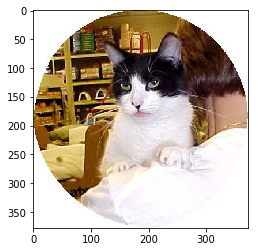

In [12]:
img = plt.imread(f'{path}valid/cats/{files[0]}')
plt.imshow(img);

In [13]:
img.shape

(378, 373, 3)

# Training on precomputed weights

In [14]:
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [15]:
arch = resnet34

In [17]:
data = ImageClassifierData.from_paths(path, tfms=tfms_from_model(arch, image_size))

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 87164177.26it/s]


100%|██████████| 32/32 [00:10<00:00,  2.91it/s]


In [19]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.049286   0.026661   0.99      
    1      0.033217   0.026482   0.99      



[0.02648177484422922, 0.99]

## Analyzing results: looking at pictures

## helper functions

In [44]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(path+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [28]:
data.val_y, len(data.val_y)

(array([0, 0, 0, ..., 1, 1, 1]), 2000)

In [23]:
data.classes

['cats', 'dogs']

In [24]:
log_preds = learn.predict()

In [25]:
log_preds.shape

(2000, 2)

In [29]:
log_preds[:10]

array([[ -0.     , -12.27993],
       [ -0.00032,  -8.05572],
       [ -0.00005,  -9.93978],
       [ -0.34563,  -1.23023],
       [ -0.00012,  -8.99036],
       [ -0.00004, -10.08398],
       [ -0.00008,  -9.42252],
       [ -0.00004, -10.20194],
       [ -0.00007,  -9.56006],
       [ -0.00029,  -8.15149]], dtype=float32)

In [32]:
# from log probabilities to 0 or 1
preds = np.argmax(log_preds, axis=1)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
# prob(dog)
probs = np.exp(log_preds[:,1])  
probs[:10]

array([0.     , 0.00032, 0.00005, 0.29223, 0.00012, 0.00004, 0.00008, 0.00004, 0.00007, 0.00029],
      dtype=float32)

Correctly classified


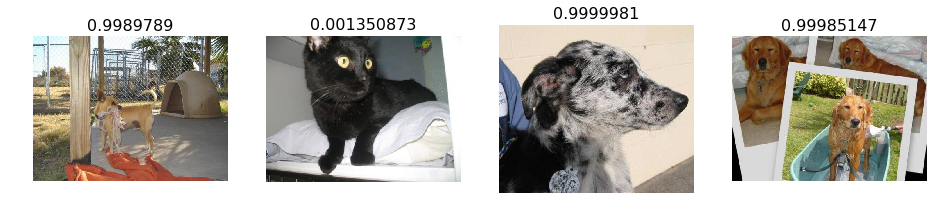

In [42]:
# A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


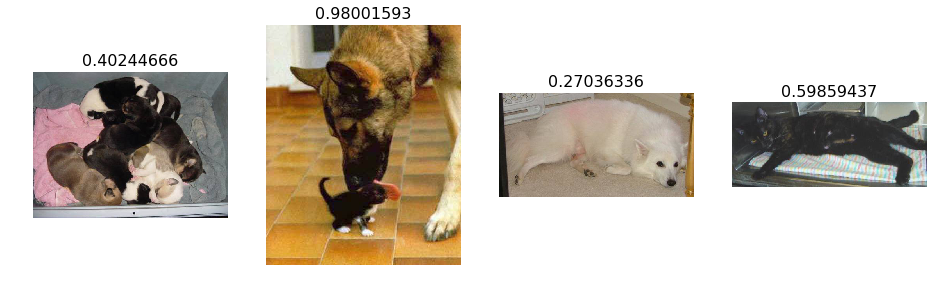

In [43]:
# A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct cats


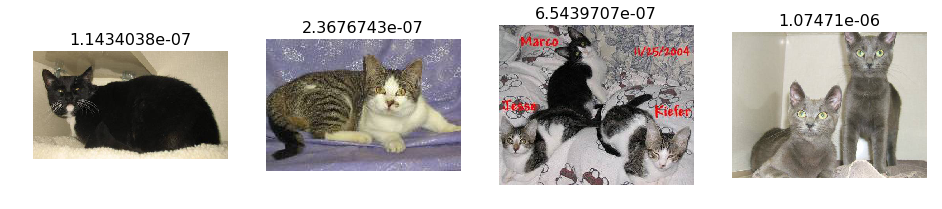

In [45]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


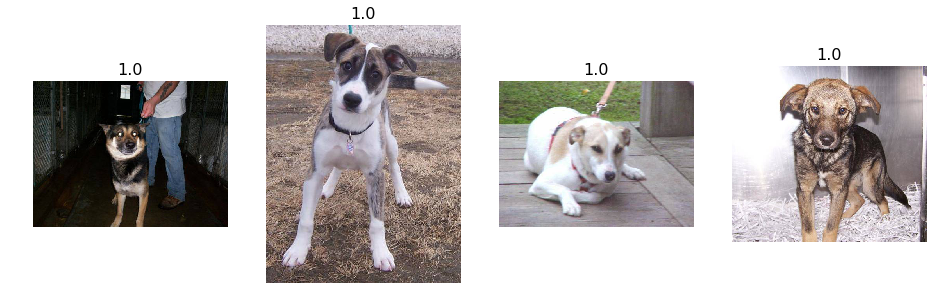

In [46]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


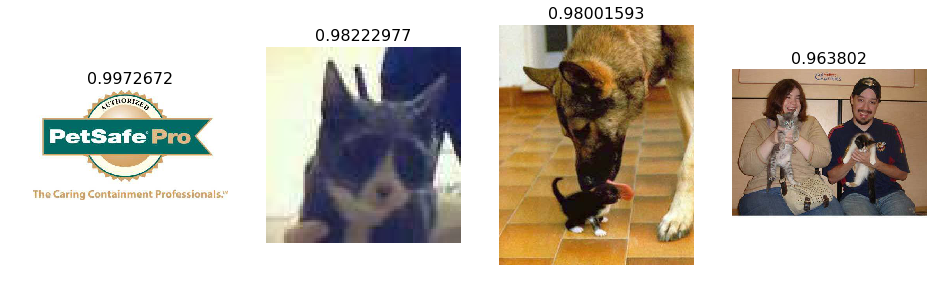

In [47]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


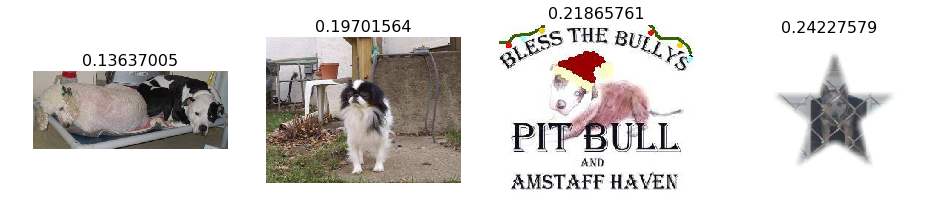

In [48]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


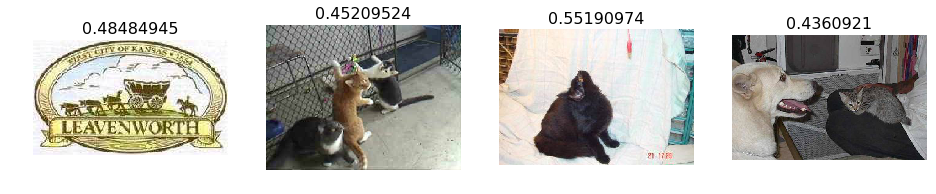

In [49]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

In [50]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [51]:
lrf = learn.lr_find()

 78%|███████▊  | 281/360 [00:04<00:01, 46.48it/s, loss=0.156]


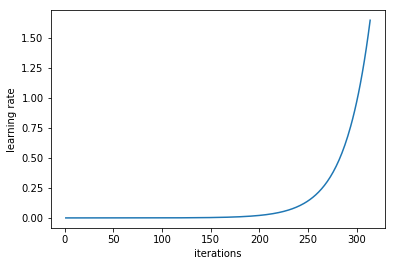

In [52]:
learn.sched.plot_lr()

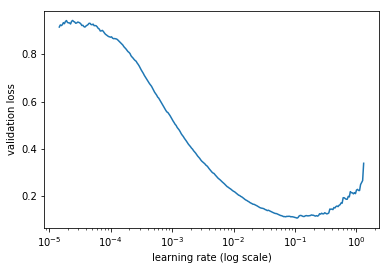

In [53]:
learn.sched.plot()

## Improving our model

### Data augmentation

In [54]:
tfms = tfms_from_model(arch, image_size, 
                       aug_tfms=transforms_side_on, max_zoom=1.1)

In [55]:
def get_augs():
    data = ImageClassifierData.from_paths(path, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [56]:
ims = np.stack([get_augs() for i in range(6)])

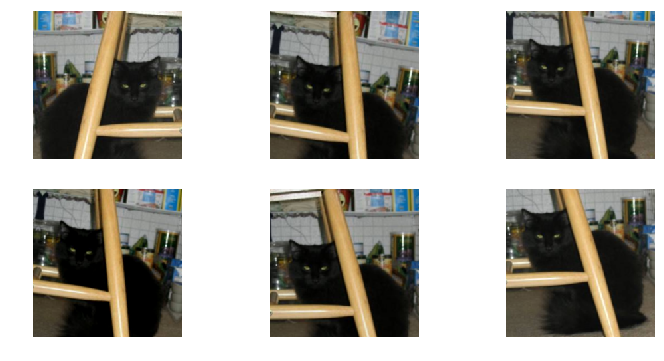

In [57]:
plots(ims, rows=2)

In [59]:
data = ImageClassifierData.from_paths(path, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [60]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.048069   0.027617   0.9895    



[0.02761670695990324, 0.9895]

In [61]:
learn.precompute = False

In [62]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.043412   0.025876   0.99      
    1      0.046037   0.026971   0.9895    
    2      0.033197   0.023877   0.992     



[0.023876903042197226, 0.992]

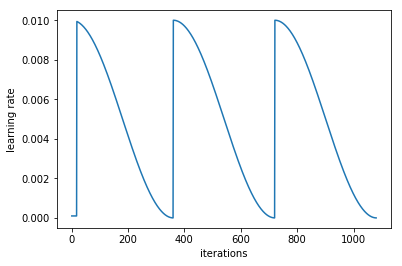

In [63]:
learn.sched.plot_lr()

### Fine-tuning and differential learning rate annealing

In [64]:
learn.unfreeze()

In [65]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

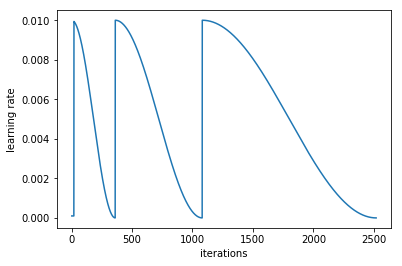

In [67]:
learn.sched.plot_lr()

In [68]:
log_preds, y = learn.TTA()

In [70]:
log_preds.shape

(5, 2000, 2)

In [75]:
y.shape

(2000,)

In [76]:
probs = np.mean(np.exp(log_preds), 0)

In [77]:
accuracy_np(probs, y)

0.996

## Analyzing results

### Confusion matrix 

In [78]:
preds = np.argmax(probs, axis=1)

In [79]:
probs = probs[:,1]

In [82]:
cm = confusion_matrix(y, preds)

[[996   4]
 [  4 996]]


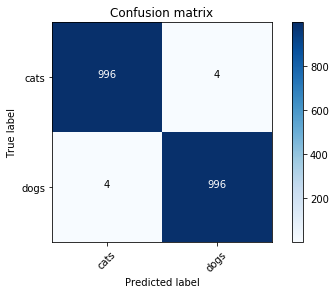

In [83]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

Most incorrect cats


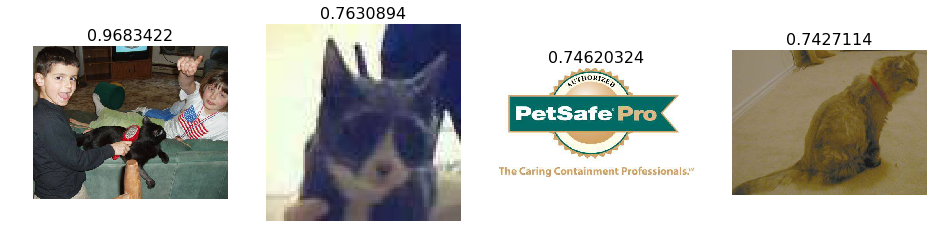

In [84]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


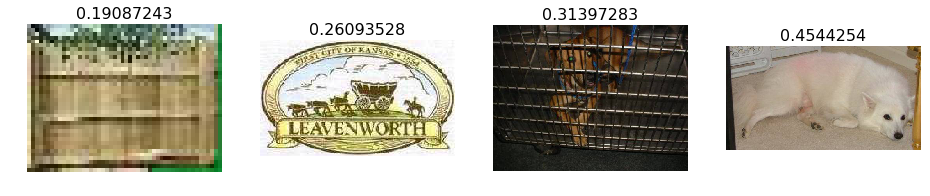

In [85]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Review: easy steps to train a world-class image classifier

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting